In [17]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as plt
import queue

PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 16                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
loc_oldest_frame = np.zeros(F).astype('int32')
phys_mem = np.full((F,2), INVALID).astype('int32')
pr_status = np.full(NP, INCOMPLETE).astype('int32')

In [18]:
def init_proc_queue() :
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
    return(pq)
    
def sim_process(M, sigma, outfile, lfrac=0.9) :
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
    sum_refs = 0
    list_locales = list()
    for count in range(M) :
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random())
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                    num_loc)
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    
    return list_locales, sum_refs

def correct_refs(alist, cent, maxpg) :
    if cent != 0 :
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else :
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]) :
        if alist[i] >= lh :
            alist[i] = lh - 1
        if alist[i] < ll :
            alist[i] = ll + 1
    return alist

In [19]:
##################################################################
# The page replacement algorithm wrapper is defined here
##################################################################
def get_oldest_frame(pr, algo_type) :
    global oldest_frame
    if algo_type == FIFO_GLOBAL :
        rv = oldest_frame
        oldest_frame += 1
        if oldest_frame == F :
            oldest_frame = 0
        return rv
        
    return INVALID

In [20]:
def init_phys_mem() :
    for i in range(F) :
        phys_mem[i,PID] = INVALID
        phys_mem[i,FRAME] = INVALID
        
def update_phys_mem(pid) :
    for i in range(F) :
        if phys_mem[i,PID] == pid :
            phys_mem[i,PID] = INVALID
            phys_mem[i,FRAME] = INVALID
        
def mem_manager(infile, outfile, pid) :
#    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr :
        addr_ref = infile.readline().strip()
        if addr_ref == '' :
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base, pg_fault = get_pageframe(pg_num, pid)
#        if pg_fault == 2 :
#            print(f'Page replaced for Process {pid} at frame: {pg_base/PAGE_SIZE}')
        if  pg_base >= 0 :
            phys_addr = pg_base + pg_offset
            outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault) + '\n')
            if pg_fault == 0 :
                pr_timing[pid] += IN_MEMORY
            elif pg_fault == 1 :
                pr_timing[pid] += MEM_FAULT
            else :
                pr_timing[pid] += PAGE_REPLACE
        else :
            print(idx)
            return INVALID
        idx += 1
        
    if idx >= num_addr :    
        return INCOMPLETE
    return COMPLETED

def get_pageframe(pnum, pr) :
    fr_num = 0
    while fr_num < F :
        if phys_mem[fr_num,PID] == pr and phys_mem[fr_num,FRAME] == pnum :
            break
        else :
            fr_num += 1

    if fr_num < F :
        return fr_num * PAGE_SIZE, 0
    
    fr_num = gen_pagefault(pnum, pr)
    if fr_num >= 0 :
        return fr_num * PAGE_SIZE, 1
    
    fr_num = page_replace(pnum, pr)
    if fr_num >= 0 :
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

def gen_pagefault(pgnum, pr) :
    fr_num = 0
    while fr_num < F and phys_mem[fr_num,FRAME] >= 0 :
        fr_num += 1
    if fr_num >= F :
        return INVALID
    phys_mem[fr_num,FRAME] = pgnum
    phys_mem[fr_num,PID] = pr
    return fr_num

def page_replace(pgnum, pr, algo=FIFO_GLOBAL) :
    cur_frame = get_oldest_frame(pr, algo)
    phys_mem[cur_frame,PID] = pr
    phys_mem[cur_frame,FRAME] = pgnum
    return cur_frame
        
def print_phys_mem() :
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F) :
        if phys_mem[i, PID] != INVALID :
            print('{:^10d} {:^6d} {:^6d}'.format(i, phys_mem[i, PID],
                                               phys_mem[i,FRAME]))
        else:
            print('Free Frame: ', i)
            
def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [21]:
pr_size = np.zeros(NP, dtype='int32')
for p in range(NP) :
    fname = 'AR_' + '{:02d}'.format(p) + '.txt'
    op = open(fname, 'w')
    npg = int(np.random.normal(10,2.5))
    nsig = int(5 * np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq, pr_size[p] = sim_process(npg, nsig, op)
    print(pg_seq, pr_size[p])
    op.write('\n')
    op.close()
    print('Written process ', p, 'to ', fname)

Process 0 requires 12 pages and has a quality 4
[5, 1, 6, 4, 0, 9, 9, 7, 9, 10, 2, 2] 32622
Written process  0 to  AR_00.txt
Process 1 requires 5 pages and has a quality 3
[3, 4, 3, 4, 2] 12743
Written process  1 to  AR_01.txt
Process 2 requires 14 pages and has a quality 4
[13, 12, 11, 2, 1, 4, 1, 3, 8, 7, 11, 8, 5, 8] 27811
Written process  2 to  AR_02.txt
Process 3 requires 11 pages and has a quality 1
[10, 4, 2, 2, 9, 3, 4, 5, 7, 7, 7] 27813
Written process  3 to  AR_03.txt
Process 4 requires 6 pages and has a quality 1
[1, 3, 5, 3, 5, 3] 13786
Written process  4 to  AR_04.txt
Process 5 requires 11 pages and has a quality 0
[3, 6, 3, 2, 6, 5, 2, 0, 7, 9, 8] 27518
Written process  5 to  AR_05.txt


In [27]:
A = np.loadtxt('AR_00.txt', dtype='int32')
print(A.max(), A.min(), A.shape)

45054 0 (32622,)


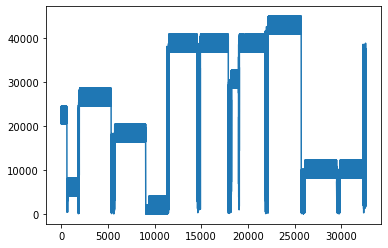

In [28]:
plt.plot(A)

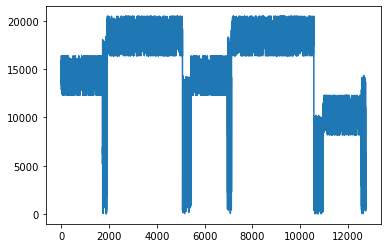

In [29]:
A = np.loadtxt('AR_01.txt', dtype='int32')
plt.plot(A)

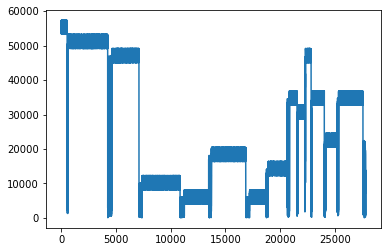

In [30]:
A = np.loadtxt('AR_02.txt', dtype='int32')
plt.plot(A)

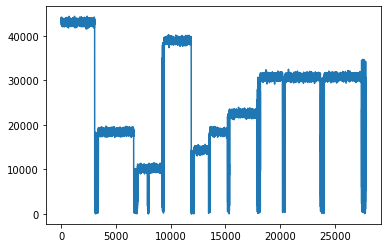

In [31]:
A = np.loadtxt('AR_03.txt', dtype='int32')
plt.plot(A)

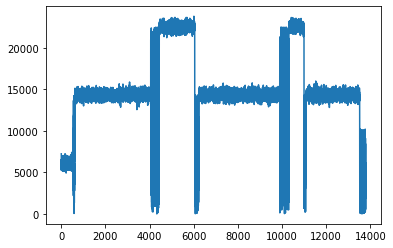

In [32]:
A = np.loadtxt('AR_04.txt', dtype='int32')
plt.plot(A)

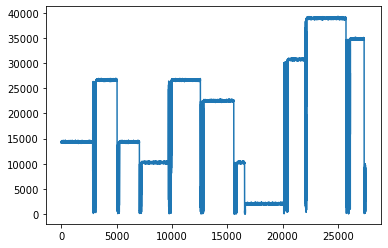

In [33]:
A = np.loadtxt('AR_05.txt', dtype='int32')
plt.plot(A)

In [34]:
# We assume that Process Simulator(s) has(ve) been run earlier.
# Otherwise do so now! Or else memory manager will fail gracefully?

# Initialise Physical Memory and Process Queue
init_phys_mem()
oldest_frame = 0
pr_que = init_proc_queue()
pr_timing = np.zeros(F).astype('int32')
IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100

# Open necessary files
infiles = list()
outfiles = list()
for i in range(NP) :
    fname = 'AR_{:02d}.txt'.format(i)
    outname = 'AR_{:02}_out.txt'.format(i)
    if os.access(fname, os.R_OK) :
        print(f'Reading Process from {fname}')
        infiles.append(open(fname, 'r'))
    else:
        print(f'Cannot open {fname} for reading')
    outfiles.append(open(outname, 'w'))

# Map logical into physical addresses and keep track of page faults
for pr in readq(pr_que) :
    rv = mem_manager(infiles[pr], outfiles[pr], pr)
    if rv == INVALID :
        print('Memory overflow error')
        break
    if rv == INCOMPLETE :
        pr_que.put_nowait(pr)
    else :
        print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
        removing from queue')
        print(f'Time taken: {pr_timing[pr]}')
        slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
        print('Slow down by {:.2f}%'.format(slow))
        update_phys_mem(pr)
#        print('Current Status of Physical Memory')
#        print_phys_mem()

# Close all files
for i in range(NP) :
    infiles[i].close()
    outfiles[i].close()
    
# Print the Pages in Physical Memory
print_phys_mem()

[0, 4, 3, 5, 1, 2]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
Process 1 (Size: 12743 Bytes) completed;         removing from queue
Time taken: 14426
Slow down by 13.21%
Process 4 (Size: 13786 Bytes) completed;         removing from queue
Time taken: 16853
Slow down by 22.25%
Process 0 (Size: 32622 Bytes) completed;         removing from queue
Time taken: 40192
Slow down by 23.21%
Process 5 (Size: 27518 Bytes) completed;         removing from queue
Time taken: 34543
Slow down by 25.53%
Process 2 (Size: 27811 Bytes) completed;         removing from queue
Time taken: 34932
Slow down by 25.60%
Process 3 (Size: 27813 Bytes) completed;         removing from queue
Time taken: 32607
Slow down by 17.24%
  Frame     PID   Page No.
  -----     ---   --------
Free Frame:  0
Free Frame:  1
Free Frame:  2
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Fram